# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
dataset = get_dataset("./data/processed/*")

INFO:tensorflow:Reading unweighted datasets: ['./data/processed/*']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/*']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch, layout):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    ax = plt.subplot(*layout)
    
    img = batch['image'].numpy()
    bboxes = batch['groundtruth_boxes'].numpy()
    classes = batch['groundtruth_classes'].numpy()
    
    # resize bboxes based on image size
    w, h, _ = img.shape
    bboxes[:, [0,2]] *= w
    bboxes[:, [1,3]] *= h
    
    # get class mappings from 'label_map.pbtxt'
    colormap = {1:'r', 2:'b', 4:'g'}
    for bb, cls in zip(bboxes, classes):
        y1, x1, y2, x2 = bb
        ax.add_patch(patches.Rectangle(xy=(x1,y1),
                                       width=(x2-x1),
                                       height=(y2-y1),
                                       linewidth=1,
                                       edgecolor=colormap[cls],
                                       facecolor='none'))
    
    # Show the camera image.
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

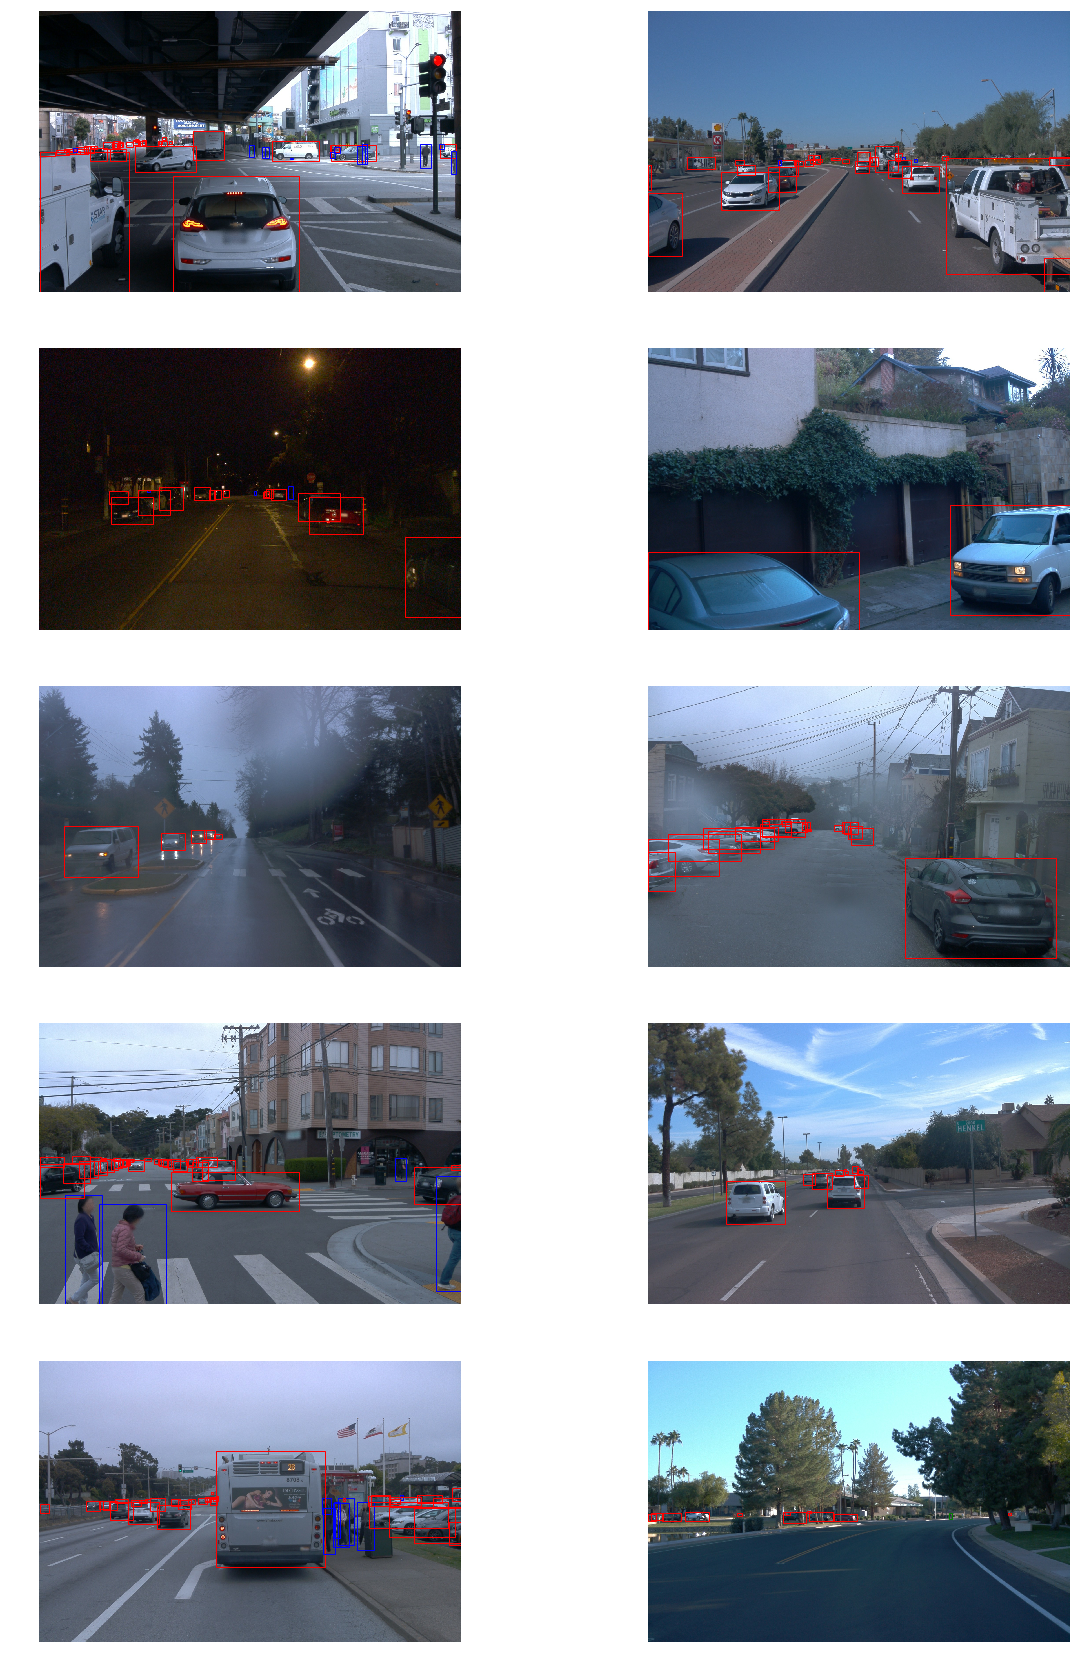

In [4]:
## STUDENT SOLUTION HERE
dataset.shuffle(10)
plt.figure(figsize=(20, 30))
for i, img in enumerate(dataset.take(10)):
    display_instances(img, [5,2,i+1])

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

## Class Distributions

We can get the distribution of the different classes to see how often each occur in our dataset.

In [5]:
labels_df = pd.DataFrame(columns=['filename','vehicle','pedestrian','cyclist'])
for i, example in enumerate(dataset.take(100)):
    fname = example['filename'].numpy().decode('utf8')
    labels_df.loc[i] = [fname, 0, 0, 0]
    classes = example['groundtruth_classes'].numpy()
    labelmap = {1:'vehicle', 2:'pedestrian', 4:'cyclist'}
    for cls in classes:
        cls_name = labelmap[cls]
        labels_df.loc[i][cls_name] += 1
print(labels_df.head())

                                            filename vehicle pedestrian  \
0  segment-10876852935525353526_1640_000_1660_000...      19          1   
1  segment-11799592541704458019_9828_750_9848_750...      26          1   
2  segment-11971497357570544465_1200_000_1220_000...      30         10   
3  segment-11928449532664718059_1200_000_1220_000...      32         19   
4  segment-1191788760630624072_3880_000_3900_000_...      18          0   

  cyclist  
0       0  
1       0  
2       0  
3       0  
4       0  


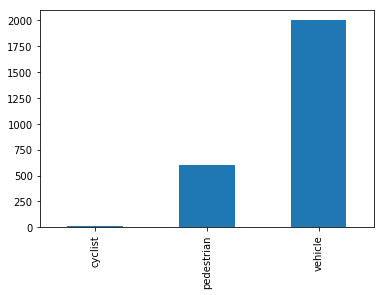

In [6]:
label_list = ['vehicle', 'pedestrian', 'cyclist']
labels_df[label_list].sum().sort_values().plot.bar()

We can see that ```vehicles``` occur most frequently, and ```cyclists``` are uncommon. We can use this information when making our train/valid/test splits. We should try to get ```cyclists``` and ```pedestrians``` present somewhat evenly across our splits.